# Import Librairies

In [9]:
%pip install numpy pandas matplotlib scikit-learn
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


Note: you may need to restart the kernel to use updated packages.


# Define datasets

In [11]:
XDOT= "XDot_2021.csv"
IOWA = "Iowa1.csv"

run=0



# Variables initialization

In [14]:
# Assume the planting date is May 1st(aka 120 from Jan. 1) for US Dataset
# For X Dot datasets, StartDay=1
startDay = 120  
index = startDay - 1
# Assume the max leaf number is 15
leafMax = 15
# Initiate the leaf number
LN = 0
# Assume the total number of initiated leaves is 5
TLN = 5
# Leaf number having the largest area
LNM = 3.53+0.46*TLN
# Assume that the largest leaf area is 750(cm^2)
AM = 750
# Initiate the accumulated thermal units starting from crop planting
ATU = 0
# Accumulated thermal units after emergence
emergATU = 0
# Accumulated thermal units after silking
silkATU = 0
# Assume the plant population is 7 (plants/m^2)
Popu = 7
# Initiate the accumulated biomass
BM = 0
# Initiate the silking state
silk = False
# Initiate the grain state
grain = False
# Thermal units needed from silking to maturity (Seed development)
finish = 1150
# Initiate harvest index
HI = 0
# Initiate grain
Grain = 0
# When silk index is greater than 3, grain starts growing
silkIndex = 0
# Initiate plant lear area
PLA = 0
# Define a helper dictionary key/value: Leaf number/individual leaf area
dic = {}
PNU_values = [27.6, 11.6, 40.1]
PNU_index = run
# the total N treatment (PNU) and had a value of 27.6 g N/m^2 (Best N treatment), low N treatment =11.6 gN/m2, High N treatment = 40.1 gN/m2
if run<3:
    PNU = PNU_values[PNU_index]
    run += 1
# Amount of N availabe in the soil. Assume SN is sufficient (above 1mgN/L)
SN = 1.1
# Accumulated amount of leaf N
LFN = 0
# Accumulated amount of stem N
STEMN = 0
# 60% accumulated N during vegetative development go to leaves, the rest go to stems.(PROPLFN = proportion of N uptake to leaves)
PROPLFN = 0.6 
# Minimum N contents for senesced leaves (MSLN) = 0.4 g N/m2
MSLN = 0.4 
# Minimum stem N concentration (MSTEMN) = 2.5 g N/kg
MSTEMN = 2.5 
# Initialize leaf area index
LAI = 0
# Accumulated amount of grain N
GRAINN = 0
# Initialize grain N concentration
GN = 0
# Initialize grain growth inhibit status is false
GInhibit = False
# Give a start value of LNT (Minimum N per unit leaf area or Minimum leaf N content, 0.55g N/m)
LNT = 0.55 
# Initialize daily N translocation
DTVN = 0
# Initialize of evaporation stage II
DSII = 1
# Initialize soil water in the top layer
SW1 = 0
# Initialize soil water in all layer
SW = 0
# Total transpirable soil water in top layer (Assume top layer: 150mm)
TTSW = 0.13*150+4
# Initialize fraction of transpirable soil water (Assume no water deflict in the beginning)
FTSW = 0.5


# List of emergATU, LN, Area, FAS, LAI, PHS, HI
lsEATU = []
lsLN = []
lsA = []
lsFAS = []
lsLAI = []
lsPHS = []
lsHI = []
lsIndex = []
lsBM = []
lsPLA = []
lsGrain = []
lsNUP = []
lsLNT = []
lsE = []
LN_list = []
TU_sum_list = []
A_list = []
FAS_list = []

# load datasets

In [17]:

f= IOWA

# Calculate saturated vapor pressure
def vaporPres(t):
    # Convert celsius to kelvin
    k = t + 273
    return np.exp(20.386-5132/k)

# Calculate slope of the saturation vapor pressure curve m
def delt(t):
    # Convert celsius to kelvin
    k = t + 273
    return (5336/k**2)*np.exp(21.07-5336/k)
# skipping in the old dataset
# df = pd.read_csv(f, skiprows=[0, 1, 2, 3, 4, 5, 6])
df = pd.read_csv(f)
# Convert the solar radiation from watt to MJ
df['srad (MJ/m^2)'] = df['srad (W/m^2)'].multiply(86400/1000000)
# Obtain the daily average temperature
df['tave (deg c)'] = (df['tmin (deg c)'] + df['tmax (deg c)']).divide(2)
# Obtain vapor pressure deflict
df['vpd'] = (df['tmax (deg c)'].apply(vaporPres) - df['tmin (deg c)'].apply(vaporPres)).multiply(0.75)
# Obtain vapor pressure curve m
df['delt'] = df['tave (deg c)'].apply(delt)
weatherData = df[['tmin (deg c)', 'tmax (deg c)', 'tave (deg c)', 'prcp (mm/day)', 'srad (MJ/m^2)', 'vpd', 'delt']]
tAve = weatherData['tave (deg c)']
sRad = weatherData['srad (MJ/m^2)']
rFall = weatherData['prcp (mm/day)']
vpd = weatherData['vpd']
delt = weatherData['delt']

# Define auxiliary functions

In [20]:

def laFTSW(ftsw):
    # Calculate the relationship between relative leaf area development and FTSW
    return 1/(1+270*np.exp(-32.2*ftsw))


def accumuPla(pla, dic, LN, A, inhibit, ftsw):
    # If the current leaf is growing and no new leaf emerge, replace the previous leaf area with the current leaf area.
    # Leaf area development will be inhibited if leaf nitrogen less than the minimum value (0.55gN/m2)
    A = A * laFTSW(ftsw)
    if not inhibit:
        if np.floor(LN) in dic:
            pla = pla - dic[np.floor(LN)] + A
        else:
            pla = pla + A
        dic[np.floor(LN)] = A
    return dic, pla


def soilEvap(sr, delt, lai, vpd):
    # Calclute daily evaporation rate
    SEP = (sr*delt*np.exp(-0.5*lai)+0.68*0.4*vpd)/(0.68*delt)
    # SEP is limited between 1.5 and 5
    if SEP < 1.5:
        SEP = 1.5
    elif SEP > 5:
        SEP = 5
    return SEP


def soilTrans(phs, vpd, sw1):
    # Step 1: Directly from biomass accumulation
    TR = phs*vpd/(0.09*1000)
    # Step 2: Water loss from top layer
    TR = TR*(2/(1+np.exp(-14*sw1/19.5)) - 1)
    return TR

def plot(lsEATU, lsLN, lsA, lsIndex, lsLAI, lsFAS, lsBM, lsHI, lsPHS, lsPLA, lsGrain, lsNUP):
    plt.figure(1)
    fig, axs = plt.subplots(5, 2)
    plt.subplots_adjust(wspace=0.5, hspace=2)
    axs[0, 0].plot(lsEATU[:len(lsLN)], lsLN)
    axs[0, 0].set_title('Leaf number vs. ATU')
    axs[0, 1].plot(lsLN, lsA)
    axs[0, 1].set_title('Leaf number vs. individual leaf area')
    axs[1, 0].plot(lsIndex[-len(lsLAI):], lsLAI)
    axs[1, 0].set_title('index vs. Leaf area index')
    axs[1, 1].plot(lsEATU, lsFAS)
    axs[1, 1].set_title('ATU vs. FAS')
    axs[2, 0].plot(lsIndex[-len(lsBM):], lsBM)
    axs[2, 0].set_title('Index vs. Accumu. biomass')
    axs[2, 1].plot(lsIndex[-len(lsHI):], lsHI)
    axs[2, 1].set_title('index vs. Harvest index ')
    axs[3, 0].plot(lsIndex[-len(lsPHS):], lsPHS)
    axs[3, 0].set_title('index vs. PHS ')
    axs[3, 1].plot(lsLN, lsPLA)
    axs[3, 1].set_title('Leaf N vs. PLA ')
    axs[4, 0].plot(lsLAI, lsPHS)
    axs[4, 0].set_title('LAI vs. PHS ')

    plt.figure(2)
    plt.plot(lsIndex[-len(lsGrain):], lsGrain)
    plt.xlabel('time (day)')
    plt.ylabel('Grain yield (g/m^2)')
    plt.title('Grain harvest starting from silk')
    plt.show()

    #plt.figure(3)
    #plt.plot(lsFAS, lsLAI)
    #plt.xlabel('Leaf Area Index')
    #plt.ylabel('Daily biomass')
    #plt.title('Relationship between photosynthesis and LAI')
    #plt.show()

    plt.figure(4)
    plt.plot(lsIndex, lsNUP)
    plt.xlabel('time (day)')
    plt.ylabel('nitrogen uptake (gN/m^2d)')
    plt.title('Nitrogen uptake potential rate')
    plt.show()

# Main program loop

In [23]:

lsX_percent = np.arange(40,95).tolist()
lsReapply_day = np.arange(180,185).tolist()
lsSN = []

for k in lsReapply_day:
    for j in lsX_percent:
        SN = PNU * j / 100

        # Loop stop either the accumulated thermal unit after silking greater than the targetted number or run out of daily data
        while silkATU <= finish and index < 300:
            if index ==k:
                SN += PNU * (100-j) / 100
            # Thermal unit is in different value before and after silking
            TU = tAve[index] - 8 if not silk else tAve[index]
            # Thermal unit cannot be negative
            TU = 0 if TU < 0 else TU
            ATU += TU
            # Daily N uptake potential rate(gN/m2d)
            NUP = TU * (PNU*5.24*(10**(-8))*(ATU**1.58)*np.exp(-(ATU/958)**2.58))
            # If no sufficient N in the soil, N uptake will be N available in the soil
            NU = NUP if SN > 1 else SN
            # N uptake will be affected if water is not sufficient
            NU = NU/(1+9*np.exp(-15.3*FTSW))

            # Crop emergence occured when accumulated thermal units greater than 87
            if ATU > 87:
                emergATU += TU
                lsEATU.append(emergATU)
                # If number of leaves is less than the max leaf number. Parameters like leaf number, fully expanded area and plant leaf area will keep updating.
                if LN < leafMax:
                    # Calculate the accumulated leaf N
                    LFN += NU * PROPLFN
                    # Calculte the accumulated stem N
                    STEMN += NU * (1 - PROPLFN)
                    # If LAI is zero, skip the calculation of N per unit leaf area (gN/m2)
                    if LAI != 0:
                        LNT = LFN/LAI * 1000
                        lsLNT.append(LNT)
                    # Check if leaf nitrogen greater than the minimum value (0.55)
                    inhibit = True if LNT < 0.55 else False 

                    # Calculate the daily leaf number
                    LN = 2.5 * np.exp(ATU*0.00225)
                    lsLN.append(LN)
                    LN_list.append(LN)
                    TU_sum_list.append(ATU)

                    A = AM * np.exp(-0.0344*((LN-LNM)**2)+0.000731*((LN-LNM)**3))
                    A_list.append(A)

                    # Append individual leaf area at each index step
                    lsA.append(A)
                    lsPLA.append(PLA)
                    # Everytime a new leaf emerges, add the individual leaf area into the plant leaf area.
                    dic, PLA = accumuPla(PLA, dic, LN, A, inhibit, FTSW)
                    # Mark the day that leaves stop growing
                    flagLeafDay = index
                    # Mark the ATU that leaves stop growing
                    flagLeafATU = ATU
                    # Total amount of vegetative N available for translocation to seed. Minimum N contents for senesced leaves (MSLN) = 0.4 g N/m2 and Minimum stem N (MSTEMN) = 2.5 g N/kg)
                    TVN = (LFN - 0.4) + (STEMN - 2.5)

                # Fraction of senesced leaf area depends on the accumulated thermal unit
                FAS = 0.00161*np.exp(0.00328*emergATU)
                lsFAS.append(FAS)
                FAS_list.append(FAS)
                
                
                # Green leaf area index
                LAI = Popu * (PLA-PLA*FAS)
                # Add a condition to determine the leaf area index so that it cannot be negative number
                LAI = LAI if LAI > 0 else 0
                lsLAI.append(LAI)
                # The radiation use efficiency (RUE) linearly depends on leaf nitrogen
                LNT = LNT if LNT > 0.55 else 0.55 
                # In the reproductive development stage, N loss in leaves results in decreasing in RUE.
                E = 0.12 + 1.5*LNT if not grain else 0.12 + 1.5*(LNT-DTVN*0.6) 
                # RUE is limited under 1.6 g M/J
                E = 1.6 if E > 1.6 else E
                # Daily photoSynthesis depends on daily solar radiation
                PHS = sRad[index]*E*(1-np.exp(-0.4*LAI))

                '''Water modelling start'''
                # If rainfall and irrigation greater than 4mm, reset 2nd stage evaporation
                DSII = 1 if rFall[index] > 4 else DSII
                # Add railfall/irrigation into top layer
                SW1 += rFall[index]
                # Top layer water storage cannot above TTSW
                SW1 = TTSW if SW1 > TTSW else SW1
                # Add railfall/irrigation into total layer
                SW += rFall[index]
                SEP = soilEvap(sRad[index], delt[index], LAI, vpd[index])
                # Conditions that triggers evaporation stageII.
                if SW1 < 1 or FTSW < 0.5:
                    DSII += 1
                    SEP *= (np.sqrt(DSII)-np.sqrt(DSII-1))
                # Transpiration rate
                TR = soilTrans(PHS, vpd[index], SW1)
                TR1 = TR*(2/(1+np.exp(-14*SW1/19.5))-1)
                # Update soil water
                SW1 = SW1 - TR1 - SEP
                SW = SW - TR - SEP
                # Soil water cannot be negative
                SW1 = 0 if SW1 < 0 else SW1
                SW = 0 if SW < 0 else SW
                # Update fraction of transpirable soil water
                FTSW = SW/135
            
                '''Water modelling end'''

                # Silking was found to occur at 67 thermal units after flag leaf full expanded
                if ATU >= flagLeafATU+67:
                    # Set the silk to be true, which will change thermal unit equation.
                    silk = True
                    # silk accumulated thermal units starts incrementing since silking
                    silkATU += TU
                    # Increment silkIndex. 3 days after silking, grains start growing
                    silkIndex += 1

                # Grain growth was assumed to begin 3 days after silking
                if silkIndex > 3:
                    # Set the grain to be true, which will affect leaf nitrogen in the next iteration.
                    grain = True
                    # Harvest index will keep increasing linearly by 0.015 per day. The maximum harvest index is 0.5
                    if HI < 0.5:
                        HI += 0.015
                    else:
                        HI = 0.5
                    # Check the status of the grain development
                    if not GInhibit:
                        # Keep updating the accumulated biomass
                        BM += PHS
                        # Keep updating the grain yield (g/m^2)
                        Grain = BM * HI
                    # Daily N translocation
                    DTVN = TVN*TU/1150
                    # Calculate the accumulated grain N
                    GRAINN += NU + DTVN
                    # Grain N concentration
                    GN = GRAINN/Grain
                    
                    # Grain growth will be inhibited if grain nitrogen less than the minimum value (11gN/kg).
                    # Grain N concentration will be reduced if grain nitrogen greater than the maximum value (16g N/kg)
                    if GN < 0.011:  #****************************************************0.011
                        GInhibit = True
                    elif GN > 0.016:
                        GN = (GRAINN - (TVN/3)*TU/1150)/Grain
                    else:
                        GInhibit = False
                lsIndex.append(index)
                lsBM.append(BM)
                lsHI.append(HI)
                lsPHS.append(PHS)
                lsGrain.append(Grain)
                lsNUP.append(NUP)
    
                

            # Increment the index for the next iteration.
            index += 1
        lsSN.append(SN)   

# Plotting graphs and printing needed values

<Figure size 640x480 with 0 Axes>

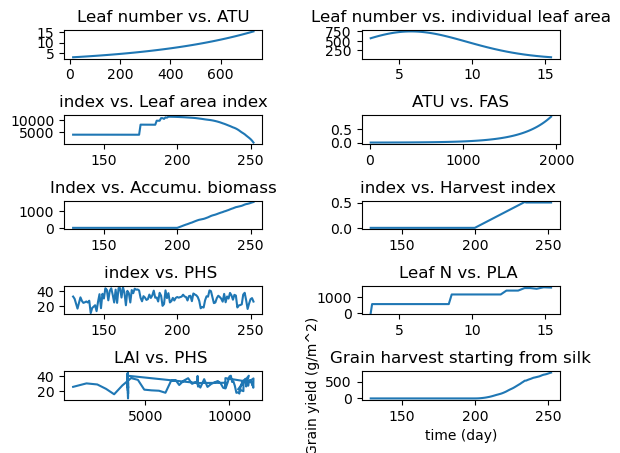

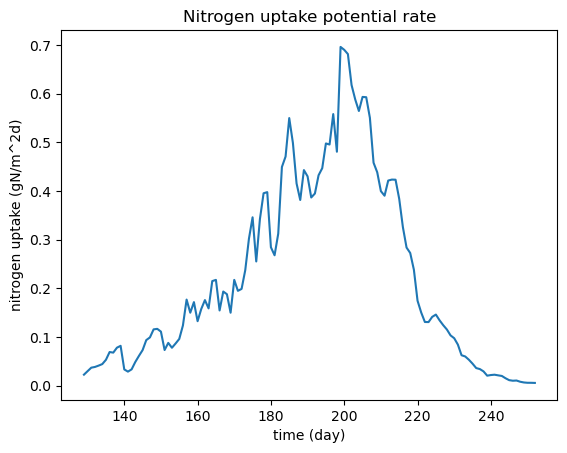

############################# LAI ##########################
689.2328873552792
############################# Grain Values ##########################
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.4638872461424998, 1.877679378630931, 4.27100362009133, 7.788586055666547, 12.173266712422135, 17.46826812143925, 23.236787671573925, 30.508331463933843, 38.84202599880409, 47.10131486313381, 57.8296868077195, 69.4045531961646, 81.83608546716984, 94.7937601304118, 107.58400043684324, 118.80578079356346, 130.97704067810963, 143.49892864428057, 159.2842811987981, 177.5111455943743, 196.54324125023655, 219.28091195386313, 242.91121082178975, 264.8542274495282, 284.7755668245032, 305.7252059926205, 329.7940249228498, 356.0724523933343, 382.6363126647474, 409.1634439478402, 434.73814541595806, 466.0288625786015, 492.87904641836434

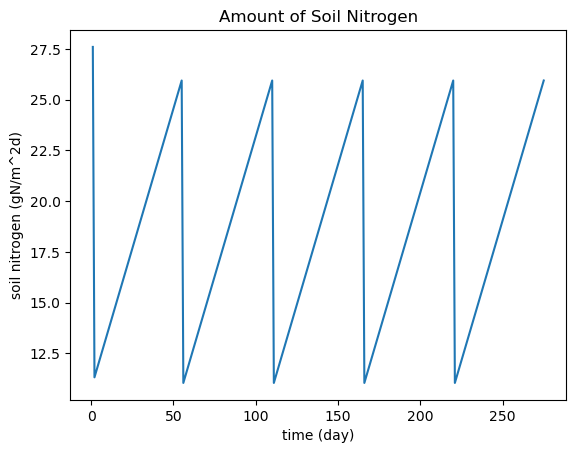

In [26]:
plot(lsEATU, lsLN, lsA, lsIndex, lsLAI, lsFAS, lsBM, lsHI, lsPHS, lsPLA, lsGrain, lsNUP)
print('############################# LAI ##########################')
print(LAI)
print('############################# Grain Values ##########################')
print(lsGrain)
print('############################# DTVN ##########################')
print(DTVN)
print('############################# GRAINN ##########################')
print(GRAINN)
print('############################# GN ##########################')
print(GN)
print('############################# RMSE ##########################')
# realVals = lsGrain
# predictedVals = lsGrain
# rmse = mse(realVals, predictedVals, squared=False)
# print(rmse)
# print('############################# MAE ##########################')
# MAE = mae(lsGrain, lsGrain)
# print ("MAE: % ", MAE)

plt.figure(5)
print(lsSN)
days = [num for num in range(1,len(lsSN)+1)]
print(days)
plt.plot(days, lsSN)
plt.xlabel('time (day)')
plt.ylabel('soil nitrogen (gN/m^2d)')
plt.title('Amount of Soil Nitrogen')
plt.show()


